## Let us consider two markovian Gaussian Process. We will find the adapted Wasserstein distance between them using our typical solver and a markovian solver and compare perofrmance

In [1]:
import os, sys, numpy as np, time, random, concurrent.futures
import matplotlib.pyplot as plt

# Set up source paths (adjust as necessary)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including markovian ones) from files.
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [6]:
T = 4
L_X = np.tril(np.ones((T, T)))
L_Y = np.tril(np.ones((T, T))) * np.sqrt(4)

seed = np.random.randint(10000)
X_sim, A = Lmatrix2paths(L_X, 3, seed=seed, verbose=False)
Y_sim, B = Lmatrix2paths(L_Y, 3, seed=seed, verbose=False)
true_val = adapted_wasserstein_squared(A, B)
print("True adapted Wasserstein squared distance:", true_val)

True adapted Wasserstein squared distance: 10.0


In [7]:
sample_sizes = [1000, 2000, 4000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 75000, 100000, 125000]
fixed_grid = 0.4
n_runs = 10

In [8]:
# Prepare lists to store metrics for each sample size and each solver.
# For non-Markovian solver:
nm_times   = {n: [] for n in sample_sizes}
nm_vals    = {n: [] for n in sample_sizes}
nm_abs_err = {n: [] for n in sample_sizes}
nm_rel_err = {n: [] for n in sample_sizes}
nm_log_err = {n: [] for n in sample_sizes}

# For Markovian solver:
m_times    = {n: [] for n in sample_sizes}
m_vals     = {n: [] for n in sample_sizes}
m_abs_err  = {n: [] for n in sample_sizes}
m_rel_err  = {n: [] for n in sample_sizes}
m_log_err  = {n: [] for n in sample_sizes}

In [9]:
for n_sample in sample_sizes:
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # Use a new random seed for each run.
        seed = np.random.randint(10000)
        
        # Generate sample paths for processes X and Y.
        X, _ = Lmatrix2paths(L_X, n_sample, seed=seed, verbose=False)
        Y, _ = Lmatrix2paths(L_Y, n_sample, seed=seed, verbose=False)
        
        # ---------------------------
        # Grid quantization (common for both solvers)
        # ---------------------------
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        # Transpose so that each row corresponds to one sample path.
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # ---------------------------
        # Non-Markovian solver
        # ---------------------------
        mu_x = qpath2mu_x(qX)  # Non-Markovian conditional measure.
        nu_y = qpath2mu_x(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        t0 = time.perf_counter()
        AW_nm = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                 nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                 n_processes=42)
        t_nm = time.perf_counter() - t0
        
        abs_err_nm = abs(AW_nm - true_val)
        rel_err_nm = abs_err_nm / true_val if true_val != 0 else np.nan
        log_err_nm = np.log10(abs_err_nm) if abs_err_nm > 0 else -np.inf
        
        nm_times[n_sample].append(t_nm)
        nm_vals[n_sample].append(AW_nm)
        nm_abs_err[n_sample].append(abs_err_nm)
        nm_rel_err[n_sample].append(rel_err_nm)
        nm_log_err[n_sample].append(log_err_nm)
        
        # ---------------------------
        # Markovian solver
        # ---------------------------
        mu_x_m = qpath2mu_x(qX, markovian=True)
        nu_y_m = qpath2mu_x(qY, markovian=True)
        (mu_x_c_m, mu_x_cn_m, mu_x_v_m, mu_x_w_m, mu_x_cumn_m, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x_m, q2v)
        (nu_y_c_m, nu_y_cn_m, nu_y_v_m, nu_y_w_m, nu_y_cumn_m, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y_m, q2v)
        t0 = time.perf_counter()
        AW_m = nested2_parallel_markovian(mu_x_cn_m, mu_x_v_m, mu_x_w_m, mu_x_idx,
                                          nu_y_cn_m, nu_y_v_m, nu_y_w_m, nu_y_idx,
                                          n_processes=42)
        t_m = time.perf_counter() - t0
        
        abs_err_m = abs(AW_m - true_val)
        rel_err_m = abs_err_m / true_val if true_val != 0 else np.nan
        log_err_m = np.log10(abs_err_m) if abs_err_m > 0 else -np.inf
        
        m_times[n_sample].append(t_m)
        m_vals[n_sample].append(AW_m)
        m_abs_err[n_sample].append(abs_err_m)
        m_rel_err[n_sample].append(rel_err_m)
        m_log_err[n_sample].append(log_err_m)
        
        print(f"Sample {n_sample}, Run {run+1}: NM AW={AW_nm:.4f}, time={t_nm:.4f}s; "
              f"M AW={AW_m:.4f}, time={t_m:.4f}s")


Running experiments for sample size: 1000


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.84it/s]

 86%|████████████████████████████████████      | 12/14 [00:00<00:00, 118.06it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 104.18it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 183.28it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 133.05it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 63.86it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 84.45it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 47.57it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 47.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 120.29it/s]
0it [00:00, ?it/s

Sample 1000, Run 1: NM AW=15.2804, time=3.1623s; M AW=11.1837, time=2.1755s


  0%|                                                    | 0/14 [00:00<?, ?it/s]


 93%|███████████████████████████████████████   | 13/14 [00:00<00:00, 128.25it/s]


 93%|███████████████████████████████████████   | 13/14 [00:00<00:00, 125.69it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 126.21it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 175.14it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 165.32it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 135.54it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 45.73it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 70.50it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 137.96it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 44.87it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 52.29it/s]

100%|████████

Sample 1000, Run 2: NM AW=15.3143, time=3.0859s; M AW=11.1307, time=2.1204s


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 135.60it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 170.64it/s]


 29%|████████████▌                               | 4/14 [00:00<00:00, 37.11it/s]

  0%|                                                    | 0/14 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 72.06it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 188.95it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 63.48it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 49.95it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 43.68it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 125.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████

Sample 1000, Run 3: NM AW=15.1477, time=3.1442s; M AW=11.2986, time=2.0426s


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 176.68it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.34it/s]


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.45it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 200.54it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 200.78it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 50.40it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 340.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 128.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 976.78it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 142.36it/s]
0it [00:00, ?

Sample 1000, Run 4: NM AW=15.7914, time=3.1642s; M AW=11.8868, time=2.0083s


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 116.95it/s]

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.61it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 134.48it/s]


  0%|                                                    | 0/14 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 103.78it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 143.82it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 200.11it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 66.56it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 59.01it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 49.24it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 42.80it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|█████████

Sample 1000, Run 5: NM AW=15.7664, time=3.1931s; M AW=11.8155, time=2.2043s


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 108.62it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 103.32it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 61.86it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 37.18it/s]


  0%|                                                     | 0/4 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 62.94it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 121.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 201.76it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 137.72it/s]
0it [00:00,

Sample 1000, Run 6: NM AW=15.5142, time=3.2008s; M AW=11.5190, time=2.1304s


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 185.96it/s]

  0%|                                                    | 0/14 [00:00<?, ?it/s]

  0%|                                                    | 0/14 [00:00<?, ?it/s]

 71%|██████████████████████████████▋            | 10/14 [00:00<00:00, 96.13it/s]

  0%|                                                    | 0/14 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 96.67it/s]





100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 173.71it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 147.84it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 84.05it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 52.75it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 33.17it/s]


100%|██████

Sample 1000, Run 7: NM AW=15.6447, time=3.2136s; M AW=11.5662, time=2.0209s


  0%|                                                    | 0/14 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 165.72it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 150.03it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 126.77it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 60.24it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 48.47it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 43.94it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.89it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 166.62it/s]



0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1045.44it/s]
0it [00:00, ?

Sample 1000, Run 8: NM AW=15.4292, time=3.2991s; M AW=11.2016, time=1.9725s


 93%|███████████████████████████████████████   | 13/14 [00:00<00:00, 126.87it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 206.11it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 185.55it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 58.87it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 33.40it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 46.91it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 228.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 177.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 110.30it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 155.59it/s]
  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/

Sample 1000, Run 9: NM AW=15.0116, time=3.0781s; M AW=10.9318, time=2.1257s


 79%|█████████████████████████████████         | 11/14 [00:00<00:00, 109.59it/s]

  0%|                                                    | 0/14 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 87.32it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 102.75it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 156.04it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 200.21it/s]

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 115.21it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 59.23it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 46.10it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 43.25it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|█████████

Sample 1000, Run 10: NM AW=15.2032, time=3.0511s; M AW=11.3609, time=1.9072s

Running experiments for sample size: 2000


 29%|████████████▌                               | 6/21 [00:00<00:00, 50.41it/s]


 62%|██████████████████████████▌                | 13/21 [00:00<00:00, 38.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 217.73it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 189.00it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 157.02it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 124.78it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Sample 2000, Run 1: NM AW=14.9484, time=4.2541s; M AW=11.1286, time=1.9995s


 48%|████████████████████▍                      | 10/21 [00:00<00:00, 43.41it/s]

 24%|██████████▍                                 | 5/21 [00:00<00:00, 46.67it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 50.60it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 69.28it/s]


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 43.05it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 195.90it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1466.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.91it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:0

Sample 2000, Run 2: NM AW=14.5472, time=4.3828s; M AW=10.9924, time=2.1834s


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.62it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 28.46it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 31.96it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 29.85it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 27.70it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 41.20it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 31.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 178.00it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 185.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 212.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 182.38it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████

Sample 2000, Run 3: NM AW=15.0666, time=4.3674s; M AW=11.5446, time=2.2297s


 95%|████████████████████████████████████████▉  | 20/21 [00:00<00:00, 88.87it/s]

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 35.17it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 40.20it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 46.34it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 29.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 122.92it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 75.11it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1586.95it/s]




100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 221.94it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00

Sample 2000, Run 4: NM AW=14.5250, time=4.5214s; M AW=11.0416, time=2.1930s


 67%|████████████████████████████▋              | 14/21 [00:00<00:00, 35.20it/s]

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 102.15it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 31.45it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 94.36it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 29.36it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 59.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.20it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 195.17it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 564.66it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0i

Sample 2000, Run 5: NM AW=14.5623, time=4.6478s; M AW=10.9754, time=2.1396s


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 50.92it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 56.63it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 30.06it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 48.10it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 48.50it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 146.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 195.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 223.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 252.52it/s]



0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 91.77it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]



Sample 2000, Run 6: NM AW=14.7541, time=5.0174s; M AW=10.9785, time=2.2620s


 86%|████████████████████████████████████▊      | 18/21 [00:00<00:00, 90.36it/s]



100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 41.08it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 64.81it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 272.12it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 27.05it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 49.35it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 28.52it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 31.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 177.57it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 179.39it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1023.00it/s]
0it [00:00, ?it

Sample 2000, Run 7: NM AW=14.9996, time=4.3103s; M AW=11.2767, time=2.3053s


 91%|███████████████████████████████████████    | 20/22 [00:00<00:00, 41.10it/s]

 71%|██████████████████████████████▋            | 15/21 [00:00<00:00, 65.07it/s]



100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 114.34it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 41.69it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 40.88it/s]


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 31.06it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 194.87it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 34.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 114.54it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████

Sample 2000, Run 8: NM AW=14.7290, time=4.3511s; M AW=11.0538, time=2.2954s


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 51.82it/s]

 24%|██████████▍                                 | 5/21 [00:00<00:00, 42.20it/s]


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 67.29it/s]

 76%|████████████████████████████████▊          | 16/21 [00:00<00:00, 31.45it/s]


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 34.07it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 53.55it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 118.01it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.13it/s]



100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1394.38it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 157.27it/s]

100%|███████

Sample 2000, Run 9: NM AW=14.3973, time=4.3473s; M AW=10.8943, time=2.2732s


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 43.08it/s]

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 46.37it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.53it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 87.66it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 42.24it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 32.87it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 120.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 142.01it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 172.80it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]


0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.88it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 84.53it/

Sample 2000, Run 10: NM AW=14.0593, time=4.5450s; M AW=10.6642, time=2.4819s

Running experiments for sample size: 4000


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 15.82it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 28.35it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 30.60it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 28.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1131.76it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 126.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 722.04it/s]


Sample 4000, Run 1: NM AW=13.4121, time=7.8614s; M AW=10.4559, time=2.3748s


 41%|█████████████████▊                         | 12/29 [00:00<00:00, 28.24it/s]

100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 31.79it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 17.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 176.65it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 169.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 176.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 83.56it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 684.34it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]




Sample 4000, Run 2: NM AW=13.9515, time=7.7859s; M AW=10.7846, time=2.4793s


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 27.90it/s]

 93%|████████████████████████████████████████   | 27/29 [00:01<00:00, 21.54it/s]

 60%|███████████████████████████                  | 3/5 [00:00<00:00, 24.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.29it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1090.85it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.87it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?i

Sample 4000, Run 3: NM AW=13.4988, time=7.8581s; M AW=10.5296, time=2.2086s


100%|███████████████████████████████████████████| 29/29 [00:02<00:00, 14.05it/s]

100%|███████████████████████████████████████████| 29/29 [00:02<00:00, 13.30it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 187.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 111.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 892.98it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 63.67it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.73it/s]



0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s

Sample 4000, Run 4: NM AW=13.5167, time=7.9892s; M AW=10.4397, time=2.5028s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 27.78it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2368.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 110.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.72it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 684.90it/s]


Sample 4000, Run 5: NM AW=13.4089, time=8.1202s; M AW=10.4192, time=2.4070s


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 15.72it/s]

100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 20.51it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 29.11it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 156.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 169.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.79it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.10it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 144.80it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?

Sample 4000, Run 6: NM AW=13.7114, time=7.6649s; M AW=10.6395, time=2.4819s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.31it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 63.50it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 167.79it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 112.57it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 231.21it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 121.58it/s]



0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 691.56it/s

Sample 4000, Run 7: NM AW=13.5889, time=7.9515s; M AW=10.6150, time=2.5311s


 66%|████████████████████████████▏              | 19/29 [00:01<00:00, 24.68it/s]

 72%|███████████████████████████████▏           | 21/29 [00:01<00:00, 12.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 202.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 184.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.68it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 108.62it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s

Sample 4000, Run 8: NM AW=13.8202, time=8.0137s; M AW=10.6847, time=2.4578s


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 28.58it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 43.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 138.41it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 157.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 131.13it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 

Sample 4000, Run 9: NM AW=13.4942, time=7.4680s; M AW=10.4428, time=2.8733s


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 20.49it/s]

100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 15.50it/s]

100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 16.12it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 36.97it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 22.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 165.25it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 118.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 171.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.14it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1385.17it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 126.43it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]


Sample 4000, Run 10: NM AW=13.8015, time=7.8696s; M AW=10.7592, time=2.6056s

Running experiments for sample size: 7000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 125.27it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 147.17it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 692.70it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 687.14it/s]


Sample 7000, Run 1: NM AW=12.9899, time=13.5215s; M AW=10.4129, time=2.5652s


100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.85it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 20.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 106.86it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1596.61it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 553.63it/s]


Sample 7000, Run 2: NM AW=12.8880, time=13.2143s; M AW=10.2538, time=2.5377s


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 17.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 158.90it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 692.82it/s]


Sample 7000, Run 3: NM AW=12.8991, time=13.5597s; M AW=10.3887, time=2.4205s


100%|███████████████████████████████████████████| 37/37 [00:04<00:00,  7.49it/s]

 40%|██████████████████                           | 2/5 [00:00<00:00, 19.70it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 117.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 165.30it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 116.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 666.82it/s]


Sample 7000, Run 4: NM AW=13.0464, time=14.3008s; M AW=10.4868, time=2.7589s


100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.48it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.48it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.06it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 80.93it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 185.76it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 186.05it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████

Sample 7000, Run 5: NM AW=12.7923, time=15.2165s; M AW=10.3182, time=2.5127s


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 17.94it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 44.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 144.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 147.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 207.84it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 579.24it/s]


Sample 7000, Run 6: NM AW=13.1504, time=14.2973s; M AW=10.6168, time=2.3341s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 167.73it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 87.11it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 151.76it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 173.50it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 85.69it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 688.95it/s]


Sample 7000, Run 7: NM AW=13.1578, time=13.7831s; M AW=10.6061, time=2.2404s


100%|███████████████████████████████████████████| 36/36 [00:02<00:00, 12.88it/s]

100%|███████████████████████████████████████████| 37/37 [00:04<00:00,  7.42it/s]

100%|███████████████████████████████████████████| 36/36 [00:05<00:00,  7.12it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 155.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 127.64it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.88it/s]


0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1397.17it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 128.61it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00,

Sample 7000, Run 8: NM AW=13.1450, time=13.9171s; M AW=10.5540, time=2.2422s


 57%|████████████████████████▍                  | 21/37 [00:02<00:02,  6.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.92it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 199.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.38it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 842.74it/s]


Sample 7000, Run 9: NM AW=13.1899, time=14.1517s; M AW=10.5603, time=2.3655s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 30.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 202.89it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.86it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 148.98it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 189.89it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 209.22it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 87.84it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it

Sample 7000, Run 10: NM AW=13.2744, time=13.9311s; M AW=10.6583, time=2.4030s

Running experiments for sample size: 10000


100%|███████████████████████████████████████████| 40/40 [00:07<00:00,  5.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 153.84it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 373.19it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 565.12it/s]


Sample 10000, Run 1: NM AW=12.7353, time=18.0777s; M AW=10.4589, time=2.3213s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 173.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1009.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 90.59it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 892.03it/s]


Sample 10000, Run 2: NM AW=12.8238, time=18.5053s; M AW=10.5716, time=2.4540s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 158.85it/s]



  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 98.10it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 129.78it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 178.47it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 61.59it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 84.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 505.22it/s]


Sample 10000, Run 3: NM AW=12.6468, time=18.9883s; M AW=10.3599, time=2.4161s


100%|███████████████████████████████████████████| 41/41 [00:06<00:00,  6.55it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 17.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 149.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 176.02it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 775.29it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 939.37it/s]


Sample 10000, Run 4: NM AW=12.8701, time=18.4414s; M AW=10.6001, time=2.6628s


100%|███████████████████████████████████████████| 41/41 [00:03<00:00, 10.84it/s]

100%|███████████████████████████████████████████| 41/41 [00:06<00:00,  6.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 81.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 143.17it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 192.25it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 692.59it/s]


Sample 10000, Run 5: NM AW=12.5998, time=18.5653s; M AW=10.3542, time=2.4834s


 71%|██████████████████████████████▍            | 29/41 [00:05<00:01,  7.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 152.00it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 127.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 125.76it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1533.01it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 124.74it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 686.80it/s]


Sample 10000, Run 6: NM AW=12.9681, time=19.0839s; M AW=10.6542, time=2.6132s


100%|███████████████████████████████████████████| 41/41 [00:07<00:00,  5.20it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 24.48it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 120.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.96it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 959.36it/s]


Sample 10000, Run 7: NM AW=12.9814, time=18.7762s; M AW=10.6937, time=2.4986s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.13it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 155.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 210.21it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 108.56it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1650.65it/s]

0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 42.37it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 677.27it/s]


Sample 10000, Run 8: NM AW=12.6126, time=18.7659s; M AW=10.3711, time=2.4979s


 90%|██████████████████████████████████████▉    | 38/42 [00:07<00:00,  6.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 149.04it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 81.75it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 827.93it/s]


Sample 10000, Run 9: NM AW=12.7068, time=18.8435s; M AW=10.4517, time=2.3626s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.09it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 161.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 110.53it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 140.00it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 546.70it/s]


Sample 10000, Run 10: NM AW=12.7760, time=19.0423s; M AW=10.5157, time=2.2796s

Running experiments for sample size: 15000


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 18.57it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.99it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 136.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 162.53it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.11it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 85.42it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


100%|██████████████

Sample 15000, Run 1: NM AW=12.3764, time=25.0247s; M AW=10.4343, time=2.5490s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 15.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 182.99it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.62it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 127.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 181.79it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 86.80it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.42it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 916.79it/s]


Sample 15000, Run 2: NM AW=12.5114, time=25.6617s; M AW=10.6137, time=2.2292s


100%|███████████████████████████████████████████| 47/47 [00:09<00:00,  5.02it/s]

100%|███████████████████████████████████████████| 46/46 [00:13<00:00,  3.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 161.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1357.82it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.81it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 84.66it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|███████████████

Sample 15000, Run 3: NM AW=12.2533, time=26.0756s; M AW=10.3222, time=2.3941s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.72it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 163.51it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 135.34it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 106.06it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 607.17it/s]


Sample 15000, Run 4: NM AW=12.4361, time=25.9741s; M AW=10.4875, time=2.5002s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 168.50it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 66.98it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 191.90it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 663.87it/s]


Sample 15000, Run 5: NM AW=12.5191, time=25.4793s; M AW=10.5510, time=2.0398s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 151.77it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.62it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 116.18it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 836.02it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 653.01it/s]


Sample 15000, Run 6: NM AW=12.4507, time=25.6745s; M AW=10.5523, time=2.2942s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 24.38it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 119.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.54it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 671.52it/s]


Sample 15000, Run 7: NM AW=12.5628, time=25.0389s; M AW=10.5571, time=2.4515s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.74it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 163.20it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 174.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.81it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 678.03it/s]


Sample 15000, Run 8: NM AW=12.1472, time=25.2598s; M AW=10.2618, time=2.4381s


100%|███████████████████████████████████████████| 47/47 [00:11<00:00,  4.02it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 124.62it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 147.21it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 152.58it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 111.52it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.91it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?i

Sample 15000, Run 9: NM AW=12.3704, time=26.9616s; M AW=10.4675, time=2.5230s


 29%|████████████▊                                | 2/7 [00:00<00:00, 15.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.53it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.54it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1019.27it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 705.99it/s]


Sample 15000, Run 10: NM AW=12.3661, time=25.1084s; M AW=10.4668, time=2.2789s

Running experiments for sample size: 20000


100%|███████████████████████████████████████████| 51/51 [00:18<00:00,  2.83it/s]

100%|███████████████████████████████████████████| 51/51 [00:18<00:00,  2.79it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.51it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.55it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1298.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 601.42it/s]


Sample 20000, Run 1: NM AW=12.1496, time=32.5747s; M AW=10.4599, time=2.5350s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 90.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.19it/s]

0it [00:00, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 184.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 670.02it/s]


Sample 20000, Run 2: NM AW=12.1088, time=33.2525s; M AW=10.4668, time=2.3665s


  0%|                                                     | 0/1 [00:00<?, ?it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 79.57it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 651.80it/s]


Sample 20000, Run 3: NM AW=11.9816, time=32.9423s; M AW=10.3011, time=2.4850s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 84.64it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.91it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 770.16it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 651.49it/s]


Sample 20000, Run 4: NM AW=12.0444, time=32.7298s; M AW=10.3660, time=2.2195s


100%|███████████████████████████████████████████| 51/51 [00:12<00:00,  4.21it/s]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 14.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1194.28it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 683.00it/s]


Sample 20000, Run 5: NM AW=11.9786, time=31.9919s; M AW=10.2805, time=2.5401s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 188.73it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1007.52it/s]


Sample 20000, Run 6: NM AW=12.0722, time=30.7487s; M AW=10.3905, time=2.2298s


100%|███████████████████████████████████████████| 51/51 [00:14<00:00,  3.55it/s]

100%|███████████████████████████████████████████| 51/51 [00:17<00:00,  2.97it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.51it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.27it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1571.49it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 691.10it/s]


Sample 20000, Run 7: NM AW=12.1495, time=31.9840s; M AW=10.5026, time=2.4341s


100%|███████████████████████████████████████████| 51/51 [00:16<00:00,  3.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 151.88it/s]



100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 179.98it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 694.31it/s]


Sample 20000, Run 8: NM AW=12.0947, time=30.9475s; M AW=10.4122, time=2.7202s


 94%|████████████████████████████████████████▌  | 49/52 [00:16<00:00,  4.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 147.71it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 114.05it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 58.38it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 190.38it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 714.05it/s]


Sample 20000, Run 9: NM AW=12.3071, time=31.8314s; M AW=10.5808, time=2.6002s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 172.29it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 68.62it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 732.12it/s]


Sample 20000, Run 10: NM AW=11.9290, time=31.9483s; M AW=10.3076, time=2.7717s

Running experiments for sample size: 25000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 19.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1554.60it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 103.04it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 993.91it/s]


Sample 25000, Run 1: NM AW=11.7934, time=36.6581s; M AW=10.3069, time=2.6900s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 11.95it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 745.52it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.67it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 150.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 127.89it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 149.78it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 176.06it/s]
0it [00:00, ?it/s]



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.43it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


Sample 25000, Run 2: NM AW=11.7530, time=38.4557s; M AW=10.2864, time=2.6774s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.12it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1349.95it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 617.08it/s]


Sample 25000, Run 3: NM AW=11.7894, time=38.4311s; M AW=10.3050, time=2.6352s


100%|███████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 115.83it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.90it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 80.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 682.56it/s]


Sample 25000, Run 4: NM AW=11.7975, time=38.7478s; M AW=10.3107, time=2.7871s


100%|███████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 139.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 174.37it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 185.01it/s]
0it [00:00, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 685.46it/s]


Sample 25000, Run 5: NM AW=11.9513, time=37.1196s; M AW=10.4601, time=2.5972s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.04it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1373.38it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1417.95it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 683.89it/s]


Sample 25000, Run 6: NM AW=11.9373, time=39.0530s; M AW=10.4351, time=2.7784s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 181.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 175.60it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 184.41it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 162.89it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 699.98it/s]


Sample 25000, Run 7: NM AW=11.7613, time=36.8857s; M AW=10.2622, time=2.8288s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.98it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.83it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 100.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 714.29it/s]


Sample 25000, Run 8: NM AW=11.8557, time=37.9108s; M AW=10.3600, time=2.8002s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 139.05it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 74.91it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 128.76it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 177.03it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 69.72it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 127.58it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 527.59it/s]


Sample 25000, Run 9: NM AW=11.8651, time=36.7553s; M AW=10.3778, time=2.5869s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 130.67it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.19it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 706.11it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 763.99it/s]


Sample 25000, Run 10: NM AW=11.9783, time=37.9362s; M AW=10.4534, time=2.5449s

Running experiments for sample size: 30000


100%|███████████████████████████████████████████| 58/58 [00:17<00:00,  3.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 119.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 181.21it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 670.34it/s]


Sample 30000, Run 1: NM AW=11.8304, time=43.3561s; M AW=10.4830, time=2.7607s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 122.80it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 145.09it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 153.87it/s]

0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1270.23it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 875.27it/s]


Sample 30000, Run 2: NM AW=11.8096, time=44.7020s; M AW=10.4374, time=2.7377s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 123.16it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 109.47it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 95.29it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 611.06it/s]


Sample 30000, Run 3: NM AW=11.7758, time=43.3301s; M AW=10.4079, time=2.6786s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 71.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 72.76it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 571.35it/s]


Sample 30000, Run 4: NM AW=11.7340, time=42.4354s; M AW=10.3394, time=2.5416s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 139.79it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 166.67it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 194.17it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 136.94it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 967.77it/s]


Sample 30000, Run 5: NM AW=11.8493, time=42.9937s; M AW=10.4799, time=2.7354s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 148.26it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 82.16it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 116.77it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1384.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 703.62it/s]


Sample 30000, Run 6: NM AW=11.7200, time=43.4441s; M AW=10.3646, time=2.8128s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.36it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1478.43it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 699.17it/s]


Sample 30000, Run 7: NM AW=11.6595, time=43.4306s; M AW=10.2959, time=2.4191s


 44%|██████████████████▊                        | 25/57 [00:09<00:11,  2.72it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 158.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 135.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 149.17it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 198.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 155.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 614.64it/s]


Sample 30000, Run 8: NM AW=11.8432, time=45.4748s; M AW=10.4808, time=2.7907s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 90.90it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 143.08it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 74.41it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.06it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 83.45it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.34it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.69it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/

Sample 30000, Run 9: NM AW=11.7769, time=44.0266s; M AW=10.4253, time=2.6305s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 137.50it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 148.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 157.90it/s]

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 832.20it/s]


Sample 30000, Run 10: NM AW=11.8150, time=42.3248s; M AW=10.4444, time=2.5451s

Running experiments for sample size: 40000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 176.80it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 640.65it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 560.29it/s]


Sample 40000, Run 1: NM AW=11.4393, time=52.9804s; M AW=10.2868, time=2.4020s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 131.28it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 181.72it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1256.53it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 780.19it/s]


Sample 40000, Run 2: NM AW=11.5484, time=51.9505s; M AW=10.4088, time=2.5939s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 134.20it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1321.46it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 757.37it/s]


Sample 40000, Run 3: NM AW=11.5571, time=52.5568s; M AW=10.3850, time=2.6068s


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1392.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 561.34it/s]


Sample 40000, Run 4: NM AW=11.6483, time=54.4464s; M AW=10.4689, time=2.7229s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 148.18it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1479.99it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 692.59it/s]


Sample 40000, Run 5: NM AW=11.6697, time=54.9792s; M AW=10.4852, time=2.5485s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 149.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 824.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 669.80it/s]


Sample 40000, Run 6: NM AW=11.5863, time=52.6106s; M AW=10.4208, time=3.0134s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 139.69it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 166.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1500.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 158.43it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 689.74it/s]


Sample 40000, Run 7: NM AW=11.5692, time=53.1495s; M AW=10.4068, time=2.7373s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.59it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 564.81it/s]


Sample 40000, Run 8: NM AW=11.5563, time=54.4011s; M AW=10.3747, time=2.7974s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 19.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 117.71it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 736.23it/s]


Sample 40000, Run 9: NM AW=11.5841, time=54.5068s; M AW=10.4224, time=2.7103s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 155.82it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.42it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 511.25it/s]


Sample 40000, Run 10: NM AW=11.4490, time=53.9749s; M AW=10.3009, time=2.6437s

Running experiments for sample size: 50000


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 12.72it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 700.80it/s]


Sample 50000, Run 1: NM AW=11.2957, time=62.7441s; M AW=10.2690, time=2.6093s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 19.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 84.59it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 90.49it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 167.38it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 157.39it/s]


0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 158.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████

Sample 50000, Run 2: NM AW=11.3584, time=65.0922s; M AW=10.3514, time=2.7034s


 83%|███████████████████████████████████▊       | 55/66 [00:28<00:06,  1.58it/s]

100%|███████████████████████████████████████████| 66/66 [00:38<00:00,  1.74it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 69.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 179.42it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 79.87it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 918.59it/s]


Sample 50000, Run 3: NM AW=11.3642, time=62.5645s; M AW=10.3463, time=2.7601s


  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 116.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.22it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 872.18it/s]


Sample 50000, Run 4: NM AW=11.4479, time=63.4428s; M AW=10.4123, time=2.6038s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 72.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 172.58it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 866.05it/s]


Sample 50000, Run 5: NM AW=11.4503, time=65.4366s; M AW=10.4197, time=2.6461s


100%|███████████████████████████████████████████| 66/66 [00:28<00:00,  2.28it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.42it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 121.48it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 661.88it/s]


Sample 50000, Run 6: NM AW=11.3687, time=62.3690s; M AW=10.3471, time=2.7543s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 134.27it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 183.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 673.13it/s]


Sample 50000, Run 7: NM AW=11.4883, time=64.2366s; M AW=10.4637, time=2.6933s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 114.21it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 189.04it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 910.82it/s]


Sample 50000, Run 8: NM AW=11.4652, time=62.9387s; M AW=10.4347, time=2.7868s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 20.92it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 167.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 139.87it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 209.77it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 711.62it/s]


Sample 50000, Run 9: NM AW=11.3031, time=62.5090s; M AW=10.2984, time=2.7801s


100%|███████████████████████████████████████████| 66/66 [00:27<00:00,  2.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 135.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 118.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1325.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 922.03it/s]


Sample 50000, Run 10: NM AW=11.3807, time=64.6301s; M AW=10.3548, time=2.7661s

Running experiments for sample size: 75000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 140.93it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1520.23it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1417.95it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 904.14it/s]


Sample 75000, Run 1: NM AW=11.1439, time=86.2482s; M AW=10.3410, time=2.7669s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 140.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 113.20it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 657.00it/s]


Sample 75000, Run 2: NM AW=11.2005, time=84.9935s; M AW=10.4005, time=2.8942s


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 132.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 128.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.84it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1390.68it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 509.08it/s]


Sample 75000, Run 3: NM AW=11.2023, time=86.6558s; M AW=10.3991, time=2.8107s


100%|███████████████████████████████████████████| 71/71 [00:55<00:00,  1.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 119.98it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 142.29it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 170.53it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 905.12it/s]


Sample 75000, Run 4: NM AW=11.1913, time=84.5577s; M AW=10.3957, time=2.9712s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.33it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 162.43it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 879.49it/s]


Sample 75000, Run 5: NM AW=11.2142, time=83.4592s; M AW=10.4112, time=2.8836s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.05it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 923.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 651.19it/s]


Sample 75000, Run 6: NM AW=11.1794, time=82.5860s; M AW=10.3747, time=2.8806s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 155.54it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 865.34it/s]


Sample 75000, Run 7: NM AW=11.1952, time=80.9152s; M AW=10.3937, time=2.6476s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.98it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 121.85it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 144.00it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 552.17it/s]


Sample 75000, Run 8: NM AW=11.2543, time=84.1534s; M AW=10.4424, time=2.5431s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.12it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 130.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 132.80it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1372.48it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 928.97it/s]


Sample 75000, Run 9: NM AW=11.1350, time=79.3850s; M AW=10.3356, time=2.3501s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 128.43it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 127.86it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 89.20it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 965.10it/s]


Sample 75000, Run 10: NM AW=11.2075, time=80.5335s; M AW=10.4056, time=2.4593s

Running experiments for sample size: 100000


 96%|█████████████████████████████████████████▎ | 75/78 [00:52<00:00,  7.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 105.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1323.12it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 112.72it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 106.28it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 618.99it/s]


Sample 100000, Run 1: NM AW=11.1471, time=102.0509s; M AW=10.4742, time=2.7224s


100%|███████████████████████████████████████████| 77/77 [01:08<00:00,  1.12it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.91it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 657.93it/s]


Sample 100000, Run 2: NM AW=11.0281, time=97.0792s; M AW=10.3569, time=2.8922s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.65it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 148.46it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 933.73it/s]


Sample 100000, Run 3: NM AW=10.9997, time=98.4643s; M AW=10.3298, time=2.7286s


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.55it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 128.57it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 935.39it/s]


Sample 100000, Run 4: NM AW=11.0614, time=99.9064s; M AW=10.3893, time=2.9522s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 81.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.97it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.38it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 107.38it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 632.72it/s]


Sample 100000, Run 5: NM AW=11.0357, time=100.2760s; M AW=10.3707, time=2.7665s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]████████████████████████████████| 1/1 [00:00<00:00, 82.28it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.75it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 175.83it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 932.90it/s]


Sample 100000, Run 6: NM AW=11.0793, time=100.1477s; M AW=10.4135, time=2.7184s


100%|███████████████████████████████████████████| 78/78 [01:09<00:00,  1.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 136.50it/s]

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.91it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 126.60it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 663.66it/s]


Sample 100000, Run 7: NM AW=11.0475, time=100.5691s; M AW=10.3655, time=2.8632s


100%|███████████████████████████████████████████| 77/77 [00:52<00:00,  1.47it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 87.55it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.14it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.27it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1247.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 890.89it/s]


Sample 100000, Run 8: NM AW=11.0824, time=97.8311s; M AW=10.4000, time=2.9257s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 121.46it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 136.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 107.86it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1232.53it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 907.27it/s]


Sample 100000, Run 9: NM AW=11.1065, time=102.6925s; M AW=10.4394, time=2.7913s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 85.68it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.07it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.39it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.02it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1391.61it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 650.28it/s]


Sample 100000, Run 10: NM AW=11.0291, time=99.7304s; M AW=10.3675, time=2.7107s

Running experiments for sample size: 125000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 133.41it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 179.33it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 574.48it/s]


Sample 125000, Run 1: NM AW=10.9444, time=115.7590s; M AW=10.3721, time=2.2552s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 126.61it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 101.96it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 745.39it/s]


Sample 125000, Run 2: NM AW=10.9458, time=106.1984s; M AW=10.3684, time=2.3952s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 82.95it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 126.06it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 957.17it/s]


Sample 125000, Run 3: NM AW=11.0118, time=108.1438s; M AW=10.4293, time=2.4477s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 114.70it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 112.83it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 997.46it/s]


Sample 125000, Run 4: NM AW=10.9306, time=107.4535s; M AW=10.3539, time=2.1657s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.75it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 65.98it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 931.65it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 552.03it/s]


Sample 125000, Run 5: NM AW=10.9839, time=105.3621s; M AW=10.4078, time=2.1716s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 125.52it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.83it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 702.45it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 974.74it/s]


Sample 125000, Run 6: NM AW=10.9610, time=106.5665s; M AW=10.3864, time=2.4468s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 81.76it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1473.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 713.44it/s]


Sample 125000, Run 7: NM AW=11.0187, time=108.7522s; M AW=10.4319, time=2.3827s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 124.99it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1153.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 710.78it/s]


Sample 125000, Run 8: NM AW=10.8838, time=106.4580s; M AW=10.3014, time=2.3412s


100%|███████████████████████████████████████████| 81/81 [00:56<00:00,  1.43it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 123.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.87it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 723.16it/s]


Sample 125000, Run 9: NM AW=10.9669, time=107.4559s; M AW=10.3866, time=2.8111s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 156.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 558.87it/s]


Sample 125000, Run 10: NM AW=10.9783, time=103.5477s; M AW=10.4017, time=2.2995s


In [10]:
def aggregate(metric_dict):
    means, stds = [], []
    for n in sample_sizes:
        arr = np.array(metric_dict[n])
        means.append(np.mean(arr))
        stds.append(np.std(arr))
    return np.array(means), np.array(stds)

nm_time_mean, nm_time_std     = aggregate(nm_times)
nm_val_mean, nm_val_std       = aggregate(nm_vals)
nm_abs_err_mean, nm_abs_err_std = aggregate(nm_abs_err)
nm_rel_err_mean, nm_rel_err_std = aggregate(nm_rel_err)
nm_log_err_mean, nm_log_err_std = aggregate(nm_log_err)

m_time_mean, m_time_std       = aggregate(m_times)
m_val_mean, m_val_std         = aggregate(m_vals)
m_abs_err_mean, m_abs_err_std = aggregate(m_abs_err)
m_rel_err_mean, m_rel_err_std = aggregate(m_rel_err)
m_log_err_mean, m_log_err_std = aggregate(m_log_err)

# Compute differences (Markovian minus Non-Markovian)
diff_time = m_time_mean - nm_time_mean
diff_val  = m_val_mean - nm_val_mean
diff_abs_err = m_abs_err_mean - nm_abs_err_mean
diff_rel_err = m_rel_err_mean - nm_rel_err_mean
diff_log_err = m_log_err_mean - nm_log_err_mean

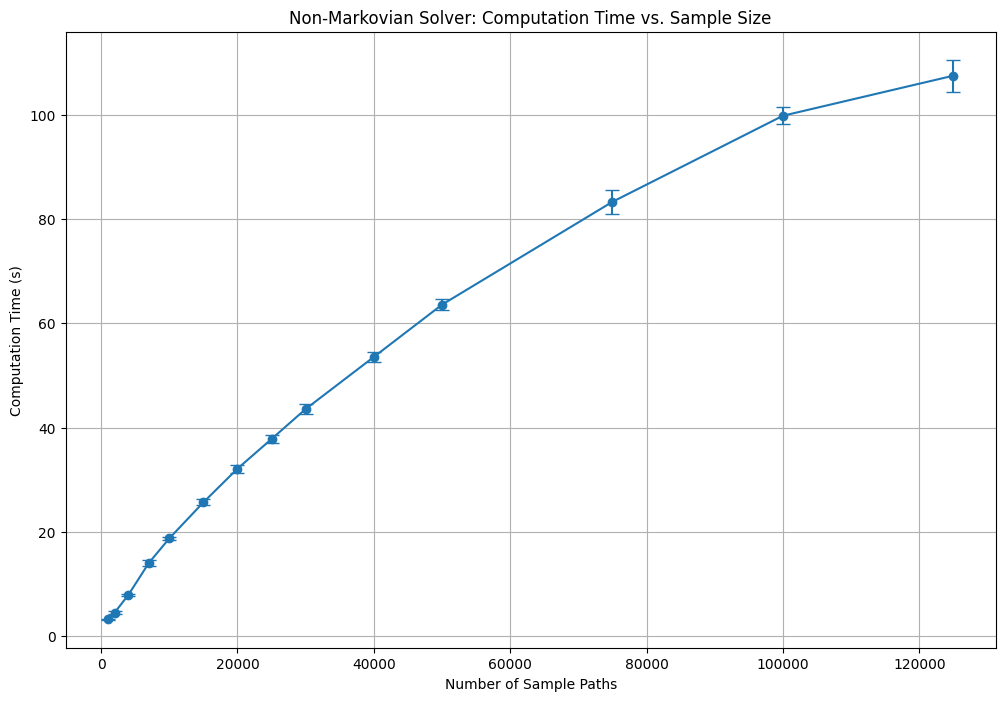

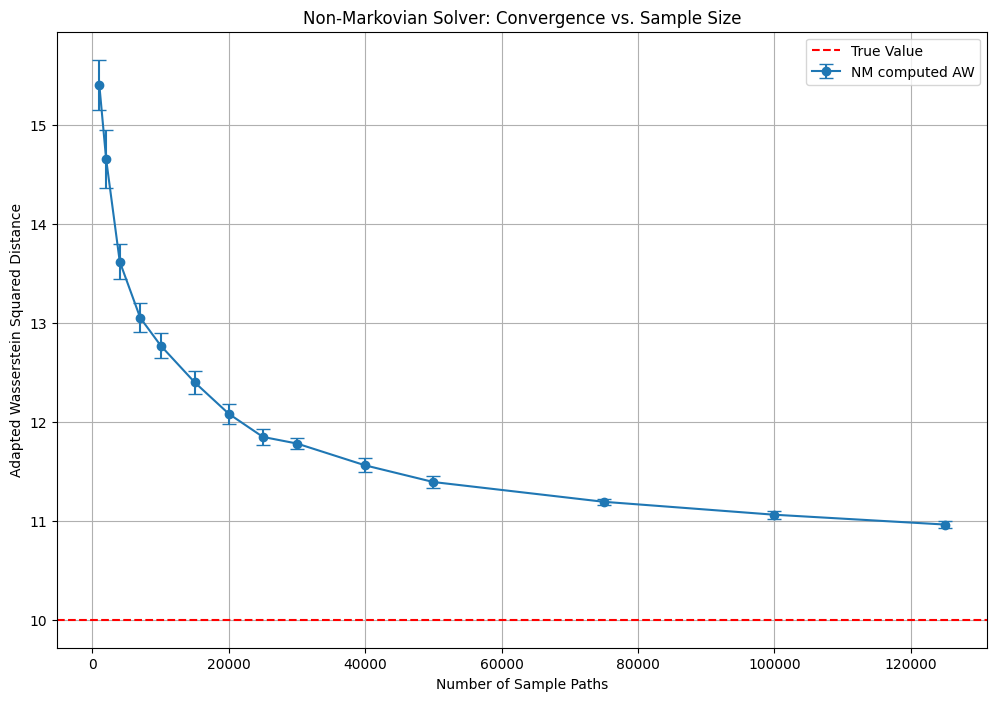

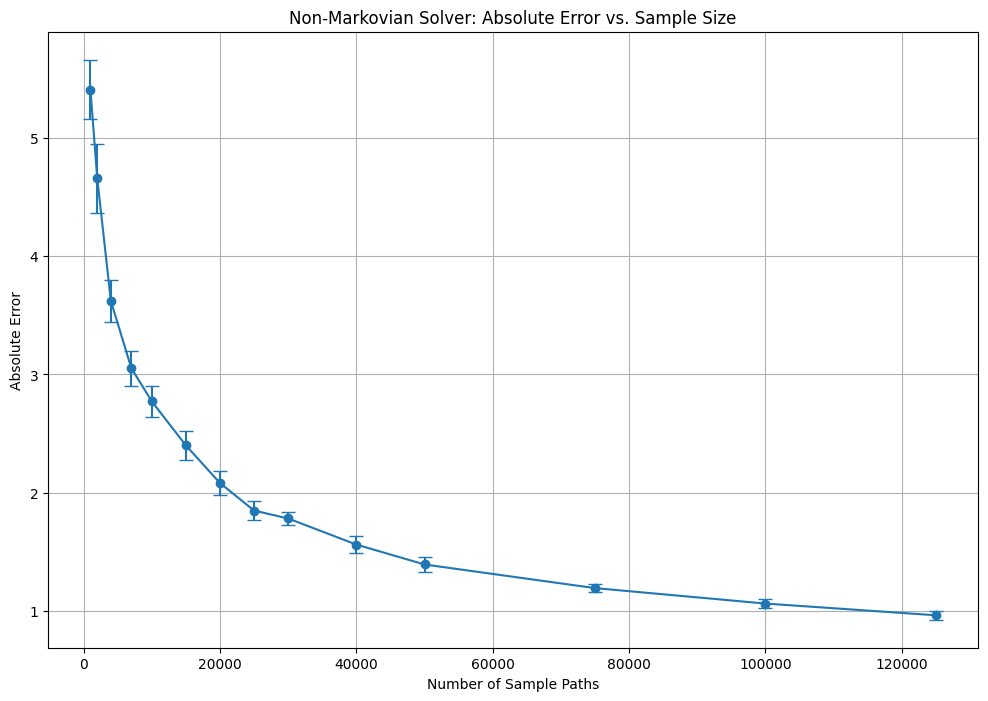

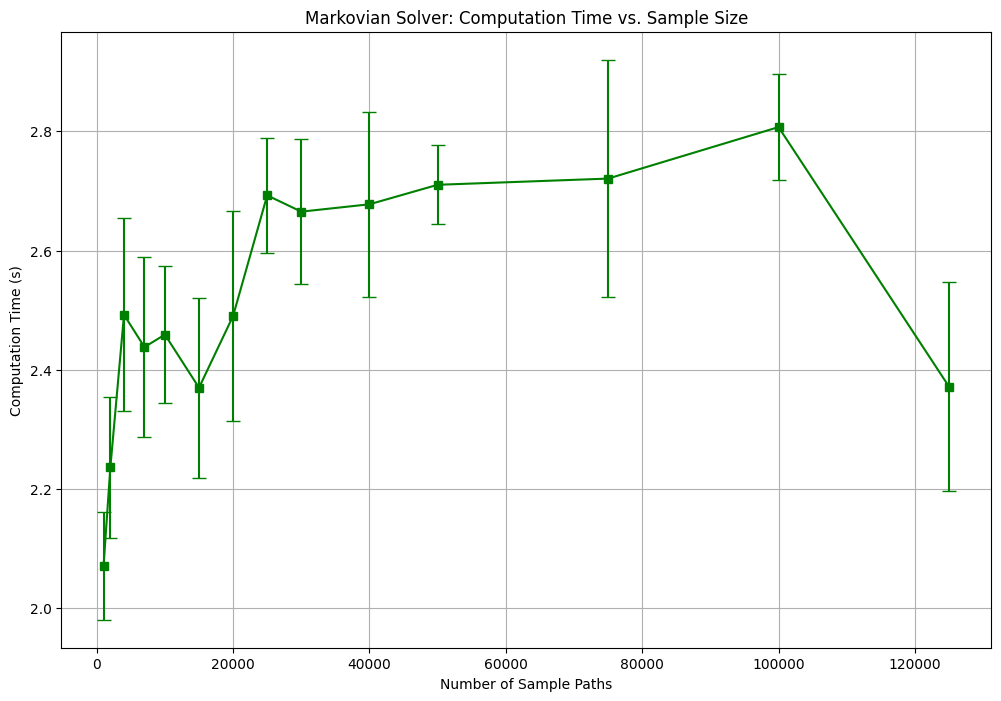

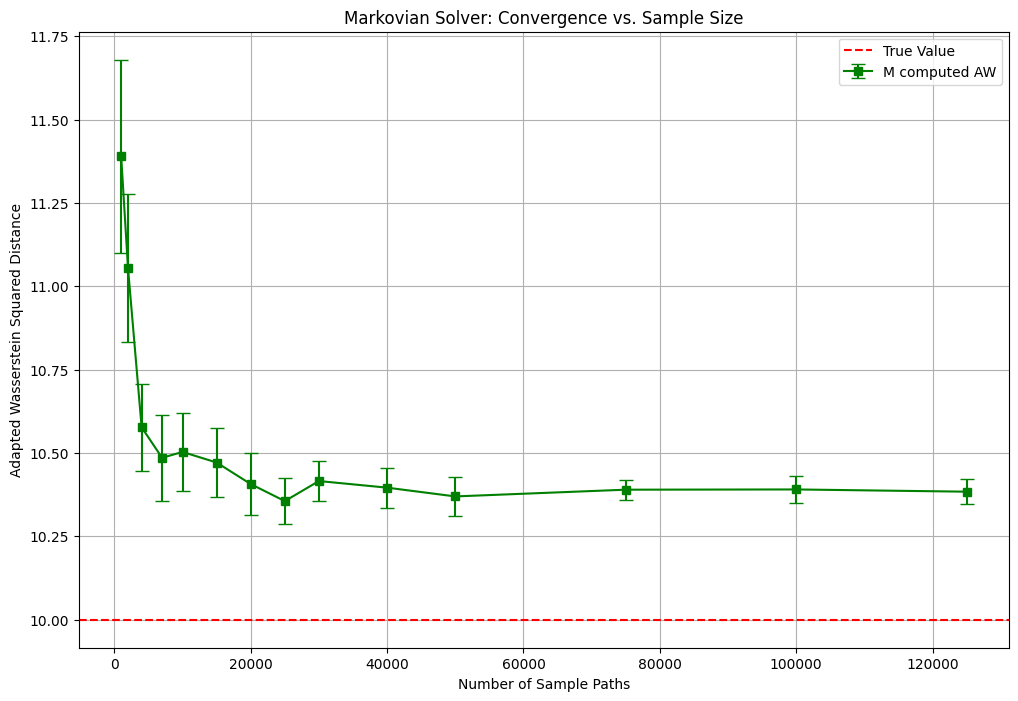

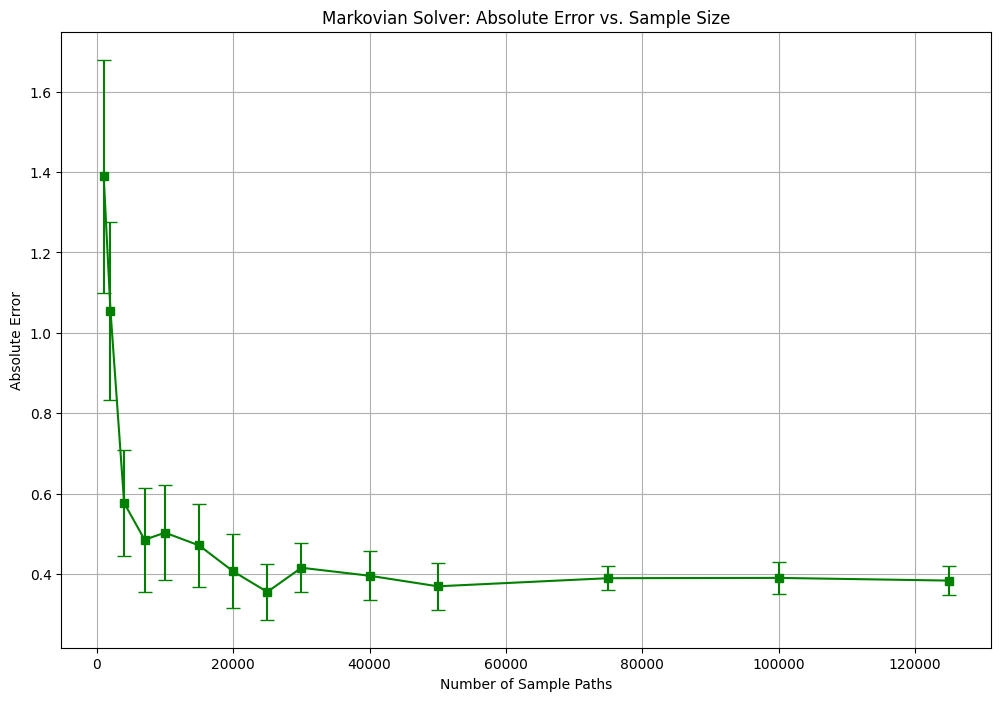

In [11]:
# ---------------------------
# (Group 1) Non-Markovian plots
# ---------------------------
plt.figure(figsize=(12, 8))
plt.errorbar(sample_sizes, nm_time_mean, yerr=nm_time_std, fmt="o-", capsize=5)
plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (s)")
plt.title("Non-Markovian Solver: Computation Time vs. Sample Size")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.errorbar(sample_sizes, nm_val_mean, yerr=nm_val_std, fmt="o-", capsize=5, label="NM computed AW")
plt.axhline(y=true_val, color="red", linestyle="--", label="True Value")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Non-Markovian Solver: Convergence vs. Sample Size")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.errorbar(sample_sizes, nm_abs_err_mean, yerr=nm_abs_err_std, fmt="o-", capsize=5)
plt.xlabel("Number of Sample Paths")
plt.ylabel("Absolute Error")
plt.title("Non-Markovian Solver: Absolute Error vs. Sample Size")
plt.grid(True)
plt.show()


# ---------------------------
# (Group 2) Markovian plots
# ---------------------------
plt.figure(figsize=(12, 8))
plt.errorbar(sample_sizes, m_time_mean, yerr=m_time_std, fmt="s-", capsize=5, color="green")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (s)")
plt.title("Markovian Solver: Computation Time vs. Sample Size")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.errorbar(sample_sizes, m_val_mean, yerr=m_val_std, fmt="s-", capsize=5, color="green", label="M computed AW")
plt.axhline(y=true_val, color="red", linestyle="--", label="True Value")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Markovian Solver: Convergence vs. Sample Size")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.errorbar(sample_sizes, m_abs_err_mean, yerr=m_abs_err_std, fmt="s-", capsize=5, color="green")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Absolute Error")
plt.title("Markovian Solver: Absolute Error vs. Sample Size")
plt.grid(True)
plt.show()
